In [1]:
%matplotlib inline
import os,sys,random

from parabola import ParabolicRegion as Parabola
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
from igmm import IGMM 
from igmm import DynamicParameter
import time

In [2]:
def get_random_motor_set(system, n_samples):
    n_motor = system.n_motor
    raw_rnd_data = np.random.random((n_samples, n_motor))

    min_values = system.min_motor_values
    max_values = system.max_motor_values

    min_values = np.array(n_samples * [np.array(min_values)])
    max_values = np.array(n_samples * [np.array(max_values)])
    motor_commands = min_values + raw_rnd_data * (max_values - min_values)
    return motor_commands

def load_h5(file_name, system=None):
    # Keeping support to old datamanager files
    motor = pd.read_hdf(file_name, 'motor').as_matrix()
    sensor = pd.read_hdf(file_name, 'sensor').as_matrix()
    return motor, sensor

def evaluate_model(system, model_tmp, sensor_evaluation, axes=None):
    model = IGMM(min_components=3,
                    max_step_components=7,
                    max_components=10,
                    forgetting_factor=0.2)#Aux model
    model.covariances_ = model_tmp.covariances_
    model.means_ = model_tmp.means_
    model.weights_ = model_tmp.weights_
    model.n_components = model_tmp.n_components
    if axes is not None:
        plt.sca(axes)
    n_samples = sensor_evaluation.shape[0]
    x_dims = range(system.n_motor)
    y_dims = range(system.n_motor,system.n_motor+system.n_sensor)
    total_norm_error = 0.
    for i in range(n_samples):
        action = model.infer(x_dims,
                             y_dims,
                            sensor_evaluation[i,:])
        system.set_action(action)
        system.executeMotorCommand()
        if axes is not None:
            plt.scatter(sensor_evaluation[i,0],sensor_evaluation[i,1], marker = 'o', s = 3., color = 'b')
            plt.scatter(system.sensor_out[0],system.sensor_out[1],marker = 'x', s = 12., color = 'r')
        total_norm_error += np.linalg.norm(sensor_evaluation[i,:]-system.sensor_out)
    return total_norm_error/float(n_samples)

In [57]:
batch_size = 15
n_batches = 30

np.random.seed(123)

In [58]:
# Results Container
start_time = time.time()

n_models = 50

motor_evaluation, sensor_evaluation = load_h5('../parabola_v2_dataset.h5')
motor_data = {}
sensor_data = {}
system = Parabola()
for i in range(n_models):
    motor_data.update({i: get_random_motor_set(system, batch_size*n_batches)})
    sensor_data_tmp = np.zeros((batch_size*n_batches,system.n_sensor))
    for j in range( batch_size*n_batches):
            system.set_action(motor_data[i][j,:])
            system.executeMotorCommand()
            sensor_data_tmp[j,:] = system.sensor_out
    sensor_data.update({i: sensor_data_tmp})

evols = []                    
for ii in range(n_models):
    ### System and Model
    system = Parabola()
    model = GMM(n_components=20)
    forgetting_factor = DynamicParameter(**{'function':'log',
                                                       'init':0.2,
                                                       'end':0.01,
                                                       'steps':n_batches})

    eval_evo = np.zeros((n_batches,))

    train_data = np.concatenate((motor_data[ii][0:batch_size+5,:],
                                sensor_data[ii][0:batch_size+5,:]), axis=1)
    model.fit(train_data)
    eval_evo[0] = evaluate_model(system, model, sensor_evaluation)
    for i in range(1,n_batches):    
         ff_ = forgetting_factor.get_value()
         k_gen = int(np.ceil((1.-ff_)*batch_size/ff_))
#          print k_gen
         train_data_gen, foo = model.sample(n_samples=k_gen)
         train_data = np.concatenate((motor_data[ii][i*batch_size:(i+1)*batch_size,:],
                                      sensor_data[ii][i*batch_size:(i+1)*batch_size,:]), axis=1)
         train_data = np.concatenate((train_data_gen,train_data),axis=0)
         model = GMM(n_components=20)
         model.fit(train_data)
         eval_evo[i] = evaluate_model(system, model, sensor_evaluation)
    evols += [eval_evo]
print("--- %s seconds ---" % (time.time() - start_time))

--- 1259.81399989 seconds ---


[ 0.92158728  1.00838685  0.90508868  0.74325741  0.59588536  0.53299251
  0.42143389  0.36590743  0.33256277  0.32584038  0.32771767  0.31386597
  0.287199    0.25876767  0.25975937  0.2518531   0.25710876  0.25921025
  0.24277637  0.24129349  0.24363902  0.25165377  0.23530195  0.23078377
  0.22543943  0.23734871  0.22337789  0.22234575  0.21719233  0.21700579]


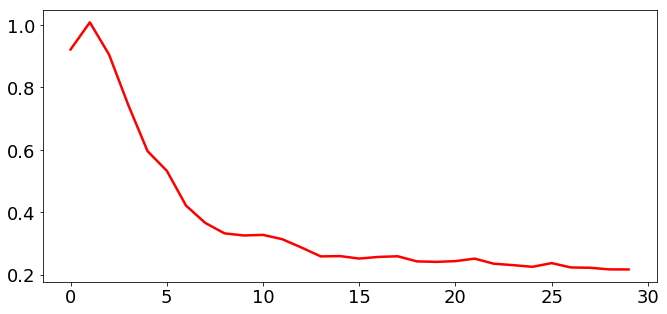

In [60]:
error = np.array(evols)
av_mean_error_calinon = np.mean(error, axis=0)
plt.plot(av_mean_error_calinon,'r')
min(av_mean_error)

print av_mean_error_calinon

In [12]:
# fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/2017 CCIA Regression Problem with IGMM/images/reg.eps',\
#             format='eps', dpi=1000, transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')

0.18231367
0.19832273


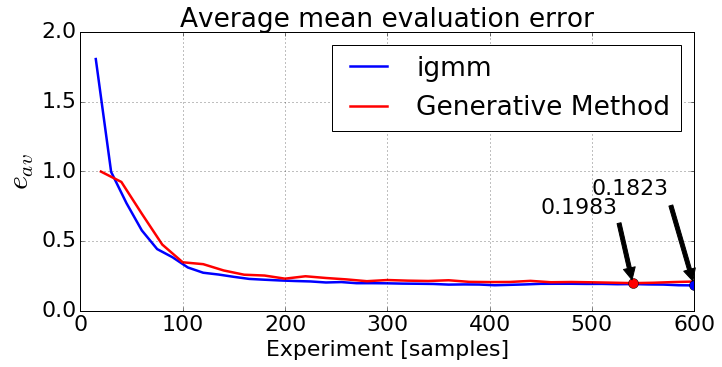

In [3]:
matplotlib.rcParams['figure.figsize'] = (11.0, 5.)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 2.5})


av_mean_error_calinon = np.array([ 0.99813598,0.92363157,0.69593188,0.47466093,0.34772055,0.33434094
,0.28924353,0.25870025,0.25269741,0.23039607,0.24759543,0.23518049
,0.2251975, 0.21224349,0.22060694,0.21610826,0.21369855,0.21890704
,0.20750441,0.20585975,0.20673638,0.21458475,0.20471699,0.20648482
,0.2042603, 0.20147147,0.19832273,0.20097741,0.20606901,0.20970343])
av_mean_error_igmm = np.array([1.80463534,0.99558548,0.77154369,0.57619111,0.44238031,0.38391999
,0.31056466,0.27287746,0.2599877, 0.24342677,0.22859661,0.2227161
,0.21750711,0.21347064,0.21038367,0.20304425,0.20590295,0.19780321
,0.19791444,0.19706652,0.19487253,0.19383922,0.19242601,0.18783428
,0.18909161,0.18828319,0.18310875,0.18612583,0.18920706,0.19335964
,0.19372064,0.19379133,0.19263216,0.19290289,0.19048273,0.19170222
,0.1890779, 0.18796091,0.18312176,0.18231367])
fig1,ax1 = plt.subplots()
plt.plot(np.linspace(15,15*40,40),av_mean_error_igmm,'b',lw=2.5)
plt.plot(np.linspace(20,20*30,30),av_mean_error_calinon,'r',lw=2.5)
print min(av_mean_error_igmm)
print min(av_mean_error_calinon)

ax1.legend(['igmm','Generative Method'])
ax1.plot(np.argmin(av_mean_error_igmm)*15+15, min(av_mean_error_igmm), 'ob',ms=10)
ax1.plot(np.argmin(av_mean_error_calinon)*20+20, min(av_mean_error_calinon), 'or',ms=10)
ax1.set_xlim([0,600.1])
ax1.set_ylim([0,2.])
ax1.grid(True)
ax1.set_xlabel('Experiment [samples]')
ax1.set_ylabel('$e_{av}$', size=30)
ax1.set_title('Average mean evaluation error')
ax1.annotate(str(0.1823), xy=(np.argmin(av_mean_error_igmm)*15+15, min(av_mean_error_igmm)), xytext=(np.argmin(av_mean_error_igmm)*15+15-100, min(av_mean_error_igmm)+0.65),
            arrowprops=dict(facecolor='black', shrink=0.05),)
ax1.annotate(str(0.1983), xy=(np.argmin(av_mean_error_calinon)*20+20, min(av_mean_error_calinon)), xytext=(np.argmin(av_mean_error_calinon)*20+20-90, min(av_mean_error_calinon)+0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

In [4]:
fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter4/images/comparisson.eps',\
            format='eps', dpi=1000, transparent=True,)
# fig1.savefig('C:/Users/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter4/images/comparisson.eps',\
#             format='eps', dpi=1000, transparent=True,)